In [1]:
import numpy as np
import pandas as pd


train_df = pd.read_csv("/kaggle/input/f1-spam-detection/train.csv")
test_df = pd.read_csv("/kaggle/input/f1-spam-detection/test.csv")

# Save test IDs before dropping
test_ids = test_df["message_id"]


In [2]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.head()


Train shape: (19100, 7)
Test shape: (900, 6)


,message_id,num_links,num_words,has_offer,sender_score,all_caps,is_spam
0,1,3,98,1,0.718607,0,0
1,2,0,170,0,0.698901,1,0
2,3,0,38,0,0.620466,0,0
3,4,0,116,0,0.701755,0,0
4,5,3,89,1,0.583621,1,1


In [3]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19100 entries, 0 to 19099
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   message_id    19100 non-null  int64  
 1   num_links     19100 non-null  int64  
 2   num_words     19100 non-null  int64  
 3   has_offer     19100 non-null  int64  
 4   sender_score  19100 non-null  float64
 5   all_caps      19100 non-null  int64  
 6   is_spam       19100 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 1.0 MB


In [4]:
train_df.isnull().sum()


message_id      0
num_links       0
num_words       0
has_offer       0
sender_score    0
all_caps        0
is_spam         0
dtype: int64

In [5]:
train_df.describe()


,message_id,num_links,num_words,has_offer,sender_score,all_caps,is_spam
count,19100.000000,19100.000000,19100.000000,19100.000000,19100.000000,19100.000000,19100.000000
mean,9550.500000,1.498272,109.651780,0.303298,0.694174,0.097853,0.091414
std,5513.839406,1.221115,51.974463,0.459695,0.188285,0.297124,0.288204
min,1.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4775.750000,1.000000,65.000000,0.000000,0.566990,0.000000,0.000000
50%,9550.500000,1.000000,110.000000,0.000000,0.699204,0.000000,0.000000
75%,14325.250000,2.000000,155.000000,1.000000,0.834200,0.000000,0.000000
max,19100.000000,9.000000,199.000000,1.000000,1.000000,1.000000,1.000000


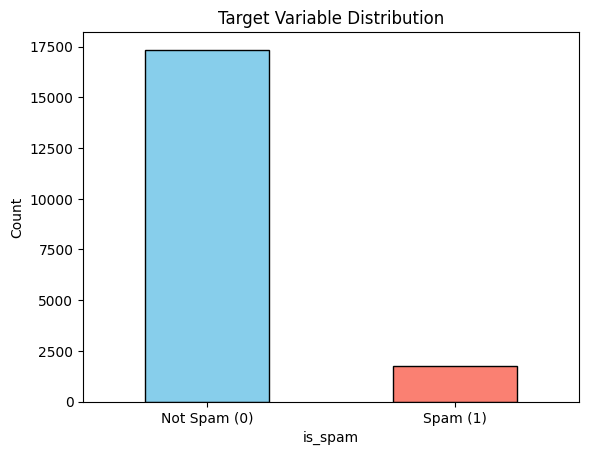

In [6]:
import matplotlib.pyplot as plt

# Count plot of is_spam
train_df["is_spam"].value_counts().plot(
    kind="bar", color=["skyblue", "salmon"], edgecolor="black"
)
plt.xticks([0, 1], ["Not Spam (0)", "Spam (1)"], rotation=0)
plt.title("Target Variable Distribution")
plt.ylabel("Count")
plt.show()


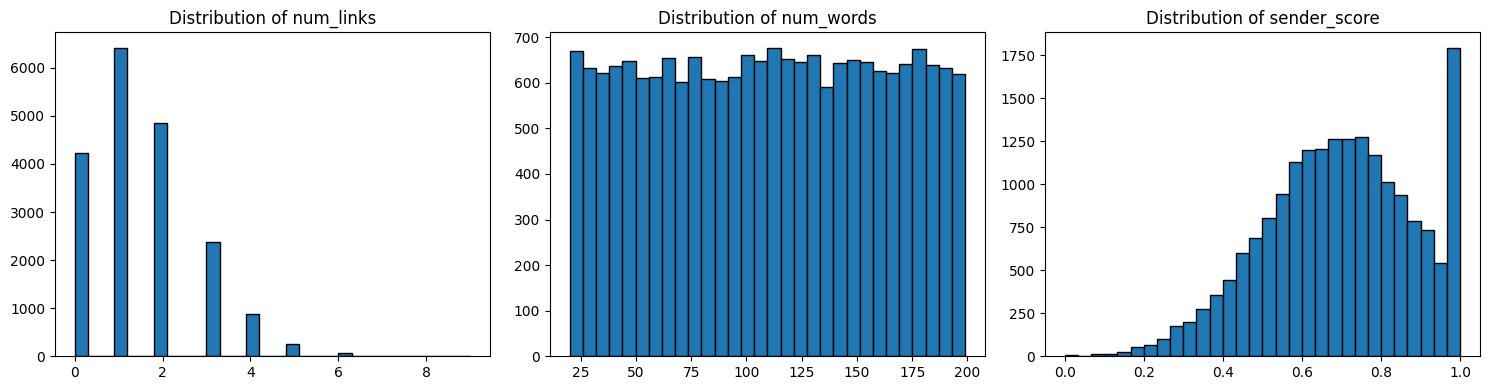

In [7]:
num_cols = ["num_links", "num_words", "sender_score"]

fig, axes = plt.subplots(1, len(num_cols), figsize=(15, 4))
for i, col in enumerate(num_cols):
    axes[i].hist(train_df[col], bins=30, edgecolor="black")
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


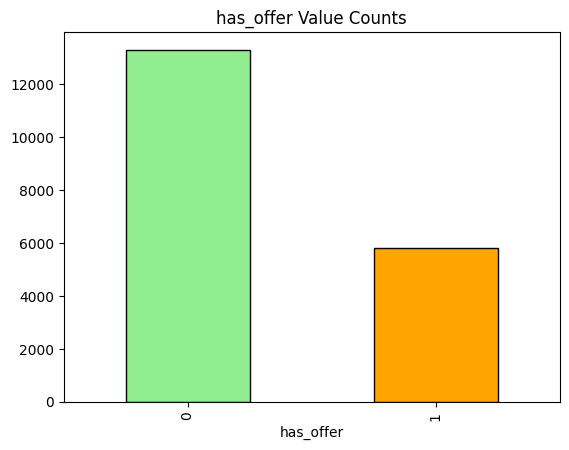

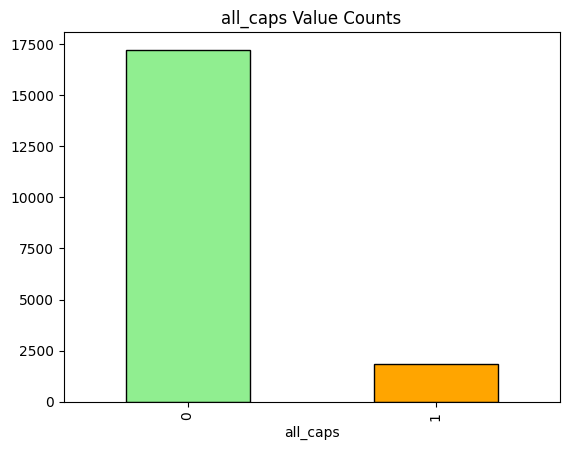

In [8]:
cat_cols = ["has_offer", "all_caps"]

for col in cat_cols:
    train_df[col].value_counts().plot(
        kind="bar", title=f"{col} Value Counts", color=["lightgreen", "orange"], edgecolor="black"
    )
    plt.show()


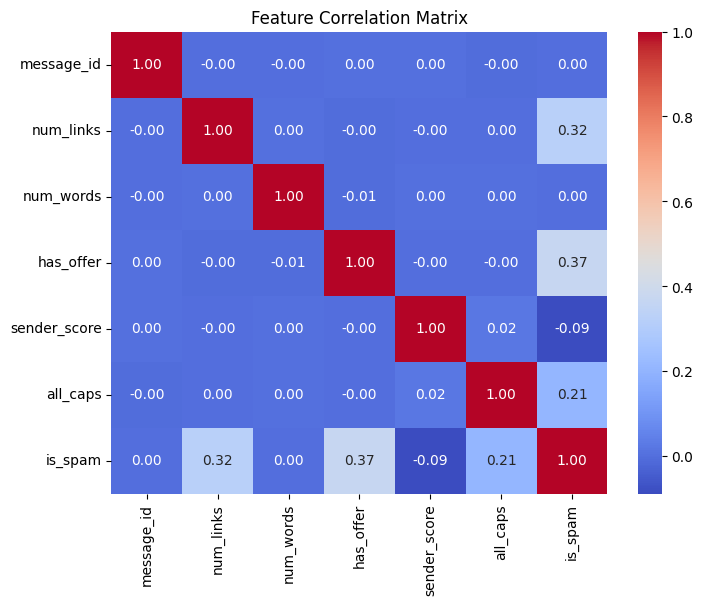

In [9]:
import seaborn as sns

# Correlation matrix
corr = train_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


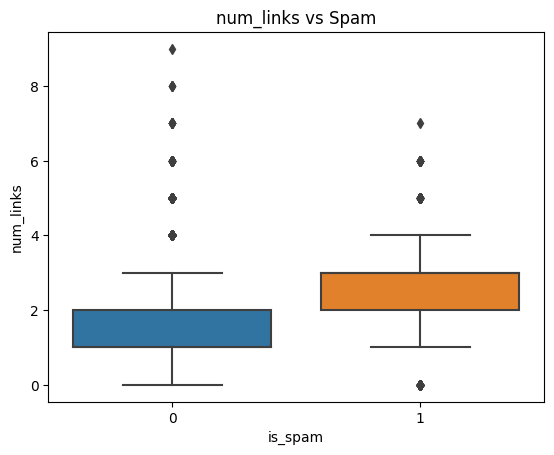

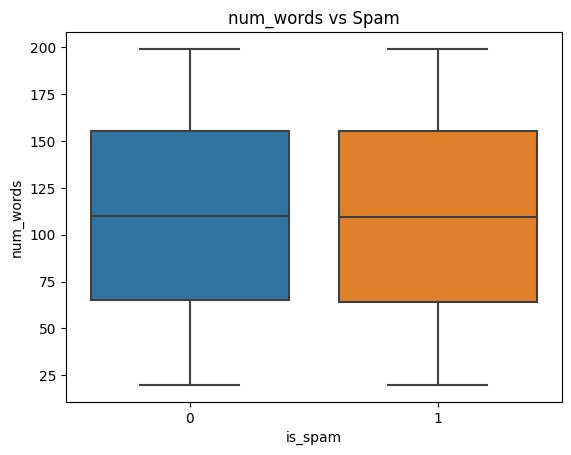

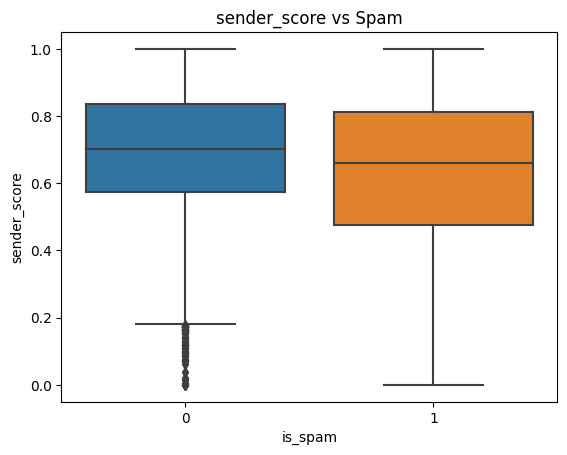

In [10]:
# Boxplots of numerical features vs target
for col in num_cols:
    sns.boxplot(x="is_spam", y=col, data=train_df)
    plt.title(f"{col} vs Spam")
    plt.show()

In [11]:
# Drop ID column for training
train_df = train_df.drop(columns=["message_id"])
test_df = test_df.drop(columns=["message_id"])

In [12]:
def add_features(df):
    if "has_offer" in df.columns and "num_links" in df.columns:
        df["offer_many_links"] = ((df["has_offer"] == 1) & (df["num_links"] > 2)).astype(int)
    if "all_caps" in df.columns and "num_links" in df.columns:
        df["caps_with_links"] = ((df["all_caps"] == 1) & (df["num_links"] > 1)).astype(int)
    if "num_links" in df.columns and "num_words" in df.columns:
        df["links_per_word"] = df["num_links"] / (df["num_words"] + 1e-6)

    for col in ["num_words", "num_links"]:
        if col in df.columns:
            df[f"log_{col}"] = np.log1p(df[col])
    return df

train_df = add_features(train_df)
test_df = add_features(test_df)


In [13]:

X_train = train_df.drop(columns=["is_spam"]).values
y_train = train_df["is_spam"].values
X_test = test_df.values

# Scale features
mean = X_train.mean(axis=0)
std = X_train.std(axis=0) + 1e-6
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std


In [14]:
class LogisticRegressionScratch:
    def __init__(self, lr=0.01, epochs=2000, reg_lambda=0.1, eps=1e-15):
        self.lr = lr
        self.epochs = epochs
        self.reg_lambda = reg_lambda
        self.eps = eps

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def log_loss(self, y_true, y_pred):
        y_pred = np.clip(y_pred, self.eps, 1 - self.eps)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for epoch in range(self.epochs):
            linear_model = np.dot(X, self.weights) + self.bias
            predictions = self.sigmoid(linear_model)

            dw = (1/n_samples) * np.dot(X.T, (predictions - y)) + (self.reg_lambda / n_samples) * self.weights
            db = (1/n_samples) * np.sum(predictions - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            if epoch % 100 == 0:
                loss = self.log_loss(y, predictions)
                print(f"Epoch {epoch}: LogLoss={loss:.4f}")

    def predict_proba(self, X):
        return self.sigmoid(np.dot(X, self.weights) + self.bias)


In [15]:
model = LogisticRegressionScratch(lr=0.1, epochs=2000, reg_lambda=0.1)
model.fit(X_train, y_train)

predictions = model.predict_proba(X_test)


Epoch 0: LogLoss=0.6931
Epoch 100: LogLoss=0.1974
Epoch 200: LogLoss=0.1598
Epoch 300: LogLoss=0.1479
Epoch 400: LogLoss=0.1422
Epoch 500: LogLoss=0.1388
Epoch 600: LogLoss=0.1366
Epoch 700: LogLoss=0.1351
Epoch 800: LogLoss=0.1340
Epoch 900: LogLoss=0.1331
Epoch 1000: LogLoss=0.1325
Epoch 1100: LogLoss=0.1320
Epoch 1200: LogLoss=0.1316
Epoch 1300: LogLoss=0.1312
Epoch 1400: LogLoss=0.1310
Epoch 1500: LogLoss=0.1307
Epoch 1600: LogLoss=0.1305
Epoch 1700: LogLoss=0.1304
Epoch 1800: LogLoss=0.1302
Epoch 1900: LogLoss=0.1301


In [16]:
submission = pd.DataFrame({
    "message_id": test_ids,
    "is_spam": predictions
})
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")


Submission file saved as submission.csv
